# Business understanding
## How well do the features in the listings data set explain the variation prices in Seattle?
* To answer this question, we will fit a Machine learning model to a set of selected categorical and numeric variables.
* Evaluate the model performance and discuss the findings of the study

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
%matplotlib inline

# Data Understanding
* Since I have used the listings data in the previous chapters, I will use the preprocessed data from the listings_EDA notebook.

In [2]:
# import data
df = pd.read_pickle('Seattle_data/clean_lisitings.pkl')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,...,9.0,10.0,f,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,...,10.0,10.0,f,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,...,10.0,10.0,f,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,...,10.0,10.0,f,WASHINGTON,f,flexible,f,f,1,1.54
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,Belltown,...,9.0,9.0,f,WASHINGTON,f,strict,f,f,1,0.89


In [3]:
# Information of the columns in the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 87 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498 non-null object
host_id                             3818

In [4]:
# Let's get a statistical summary of the numeric values.
# There are 34 numeric variables in this data set, however not all of them really make any statistical meaning.
# Features like the id, scrape_id, host_id, latitude and logitude can be excluded from the study.
df.describe()

,id,scrape_id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,95.587218,99.973808,7.154531,7.154531,47.628961,-122.333103,3.349398,...,22.223415,94.786799,9.699057,9.632268,9.823468,9.842064,9.676008,9.546359,2.946307,1.990416
std,2.962660e+06,0.000000e+00,1.458382e+07,11.163132,1.618386,28.620995,28.620995,0.043052,0.031745,1.977599,...,37.730892,6.045120,0.649705,0.744855,0.547703,0.522425,0.591225,0.713340,5.893029,1.677888
min,3.335000e+03,2.016010e+13,4.193000e+03,17.000000,0.000000,1.000000,1.000000,47.505088,-122.417219,1.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,100.000000,100.000000,1.000000,1.000000,47.609418,-122.354320,2.000000,...,2.000000,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.830000
50%,6.118244e+06,2.016010e+13,1.055814e+07,100.000000,100.000000,1.000000,1.000000,47.623601,-122.328874,3.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,100.000000,100.000000,3.000000,3.000000,47.662694,-122.310800,4.000000,...,26.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.660000
max,1.034016e+07,2.016010e+13,5.320861e+07,100.000000,100.000000,502.000000,502.000000,47.733358,-122.240607,16.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


# Data preparation

In [5]:
# select out only the numeric columns
num_vars = df.select_dtypes(include=['int','float']).copy()

In [6]:
num_vars.shape

(3818, 21)

* There are only 21 columns numeric values 

In [7]:
num_vars.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'bathrooms',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [8]:
# Longtitude and latitudes are still included in the numeric variables.
# I will drop these to columns
# Host_listings_count is a duplicate of host_listings_count, I will drop one of the columns.
final_num_var = num_vars.drop(['latitude','longitude','host_listings_count'],axis=1)

In [9]:
final_num_var.describe().T

,count,mean,std,min,25%,50%,75%,max
host_response_rate,3818.0,95.587218,11.163132,17.00,100.00,100.000000,100.000000,100.00
host_acceptance_rate,3818.0,99.973808,1.618386,0.00,100.00,100.000000,100.000000,100.00
host_total_listings_count,3818.0,7.154531,28.620995,1.00,1.00,1.000000,3.000000,502.00
bathrooms,3818.0,1.258381,0.589369,0.00,1.00,1.000000,1.000000,8.00
bedrooms,3818.0,1.307229,0.882785,0.00,1.00,1.000000,2.000000,7.00
beds,3818.0,1.735202,1.139393,1.00,1.00,1.000000,2.000000,15.00
price,3818.0,127.747708,89.139181,20.00,75.00,100.000000,150.000000,999.00
security_deposit,3818.0,254.484832,103.176473,95.00,250.00,254.484832,254.484832,995.00
cleaning_fee,3818.0,61.710904,41.725079,5.00,35.00,61.710904,65.000000,300.00
extra_people,3818.0,10.667627,17.585922,0.00,0.00,0.000000,20.000000,300.00


In [10]:
#Numeric columns with more than half of the values missing.
no_nulls =set(final_num_var.columns[final_num_var.isnull().mean()>0.0])
no_nulls = pd.DataFrame(no_nulls,columns=['Column_with_any_NAN'])
no_nulls

,Column_with_any_NAN


* There are no numeric columns with any missing values 

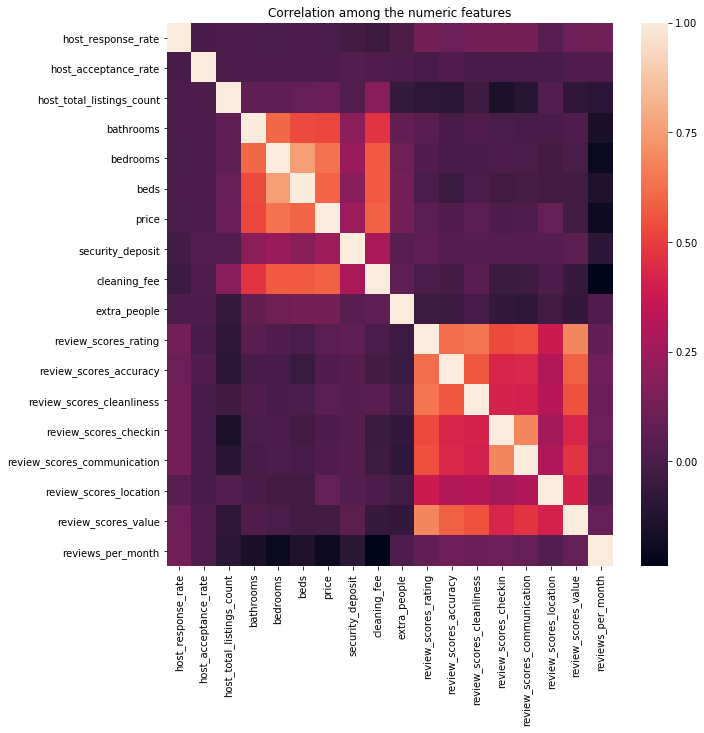

In [11]:
# what is the correlation among various numeric variables?
plt.figure(figsize=(10,10))
ax = sns.heatmap(final_num_var.corr());
plt.title('Correlation among the numeric features');

* Based on the heatmap, there are 3 clusters of correlations in the Seattle listings data.
* We see a fairly strong correlation among the scores and reviews (lower_right corner of the heatmap)
* There is a strong correlation among the availability measures which is expected since they are cummulative(centre)
* There is a fairly strong correlation among the fees, prices and room specifics (upper left corner)

# What features in the listings data set explain the variation prices in Seattle?
* To answer this question, I create the indepedent variables (X-matrix) and the response variable (y) which is the price in this case.
* First I will create the features fusing the create_features function below.
* Then I train, fit and evaluate the features to a linear regression model.
* Model training, fitting and evaluation is done in the lm_mod function.
* I have opted for the Linear regression model because it is easy to work with and interprete.

# Features

In [12]:
def create_features(df):
    '''
    INPUT
    df - dataframe of only the relevant columns
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the columns that are not relevant for the predicton.
    2. Drop any rows with missing values.
    3. Remove outliers below the 1% and above the 99% percentiles based on the Price column.
    4. Create y as the price column
    5. Create dummy columns for all the categorical variables, drop the original columns
    6. Create X as all the columns that are not the price column
    '''        
    # Removing outliers 
    df = df[df['price'].between(df['price'].quantile(.01), df['price'].quantile(.99))] 

    # Drop any NaNs left in the dataframe
    df = df.dropna(how='any',axis=0)
    # Define the reponse variable
    
    y = df['price']
    
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    # for each cat add dummy var, drop original column    
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        
    # Define the response column
    X = df.drop(['price'],axis=1)
    
    return X, y 

# Modelling

In [13]:
def lm_mod(X, y,test_size = .30, random_state=42, plot=True):
    
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    Plots - Predictions & Actual and Predictions & Differences
    Table - Features' importance arranged in descending orders of the absolute coefficients.
    '''
    
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42);
    
    # Fit the model and obtain pred response
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    
    # r2 and mse values from the train and test sets
    r2_scores_train=r2_score(y_train, y_train_preds)
    print ("r2_scores_train = {}".format(r2_scores_train))
    r2_scores_test=r2_score(y_test, y_test_preds)
    print ("r2_scores_test = {}".format(r2_scores_test))
    
    
    mse_score_train=mean_squared_error(y_train, y_train_preds)
    print ("mse_score_train = {}".format(mse_score_train))
    mse_score_test=mean_squared_error(y_test, y_test_preds)
    print ("mse_score_test = {}".format(mse_score_test))
    
    preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]));
    preds_vs_act.columns = ['actual', 'preds'];
    preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds'];


    plt.plot(preds_vs_act['preds'], preds_vs_act['actual'], 'bo');
    plt.xlabel('predicted');
    plt.ylabel('Actual');
    plt.title('Predictions & Actual');
    plt.show()
    
    plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'ro');
    plt.xlabel('predicted');
    plt.ylabel('diff');
    plt.title('Predictions & Difference');
    plt.show()
    
    coefs_df = pd.DataFrame()

    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    print(coefs_df.sort_values('abs_coefs', ascending=False))
       
    return lm_model

### Model 1 : Predicting prices with only the numeric values
* In this model, I will train, fit and test numeric features.

In [14]:
X,y = create_features(final_num_var)

r2_scores_train = 0.5270769094182601
r2_scores_test = 0.5455478770788318
mse_score_train = 2502.3736767172536
mse_score_test = 2383.430051454342


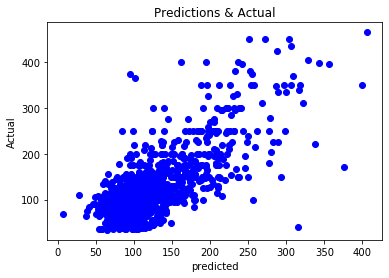

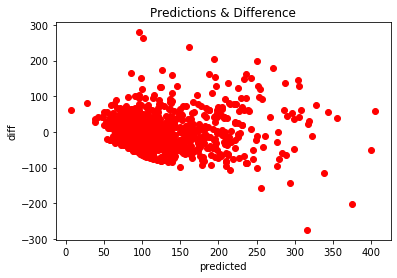

                        est_int         coefs     abs_coefs
4                      bedrooms  2.296310e+01  2.296310e+01
3                     bathrooms  2.036018e+01  2.036018e+01
14       review_scores_location  1.430670e+01  1.430670e+01
15          review_scores_value -1.229499e+01  1.229499e+01
5                          beds  1.063553e+01  1.063553e+01
10       review_scores_accuracy  5.619833e+00  5.619833e+00
13  review_scores_communication  3.011844e+00  3.011844e+00
16            reviews_per_month -2.883756e+00  2.883756e+00
12        review_scores_checkin -2.760087e+00  2.760087e+00
11    review_scores_cleanliness  2.483402e+00  2.483402e+00
7                  cleaning_fee  4.173700e-01  4.173700e-01
9          review_scores_rating  3.823573e-01  3.823573e-01
8                  extra_people  1.265505e-01  1.265505e-01
0            host_response_rate  7.582667e-02  7.582667e-02
6              security_deposit  4.310445e-02  4.310445e-02
2     host_total_listings_count  3.98495

In [15]:
model_1 = lm_mod(X,y)

# Model Evaluation _ Model 1
* Based on the model's r2 score, numeric varibles explain only 55% and 52% of the variations in listings prices in the test and train sets respectively
* The number of bedrooms has the greatest effect on the price, one extra bedroom increases the price by 23 dollars.
* The security_desosit has the least effect on the prices, a unit change in the the security deposit increases the price by less than a cent dollars.
* Based on the Prediction VS Actual plot, the model is performs better when predicting prices between 50 and 200. This means that the model fails to predict extremely high and low prices.

### Model 2 : Predicting prices with numeric categorical features
* In this model, I combine the numeric features from the previous model with selected categorical features

In [16]:
# Categorical columns.
cat_vars = df.select_dtypes(include=['object']).copy()
cat_vars.head().T

,0,1,2,3,4
listing_url,https://www.airbnb.com/rooms/241032,https://www.airbnb.com/rooms/953595,https://www.airbnb.com/rooms/3308979,https://www.airbnb.com/rooms/7421966,https://www.airbnb.com/rooms/278830
last_scraped,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04
name,Stylish Queen Anne Apartment,Bright & Airy Queen Anne Apartment,New Modern House-Amazing water view,Queen Anne Chateau,Charming craftsman 3 bdm house
summary,NaN,Chemically sensitive? We've removed the irrita...,New modern house built in 2013. Spectacular s...,A charming apartment that sits atop Queen Anne...,Cozy family craftman house in beautiful neighb...
space,Make your self at home in this charming one-be...,"Beautiful, hypoallergenic apartment in an extr...","Our house is modern, light and fresh with a wa...",NaN,Cozy family craftman house in beautiful neighb...
description,Make your self at home in this charming one-be...,Chemically sensitive? We've removed the irrita...,New modern house built in 2013. Spectacular s...,A charming apartment that sits atop Queen Anne...,Cozy family craftman house in beautiful neighb...
neighborhood_overview,NaN,"Queen Anne is a wonderful, truly functional vi...",Upper Queen Anne is a charming neighborhood fu...,NaN,We are in the beautiful neighborhood of Queen ...
notes,NaN,What's up with the free pillows? Our home was...,Our house is located just 5 short blocks to To...,NaN,Belltown
transit,NaN,"Convenient bus stops are just down the block, ...",A bus stop is just 2 blocks away. Easy bus a...,NaN,The nearest public transit bus (D Line) is 2 b...
thumbnail_url,NaN,https://a0.muscache.com/ac/pictures/14409893/f...,NaN,NaN,NaN


In [17]:
# I maninly interested in categorical values that can be converted to create variables.
# These include columns that include booleans and classes.
#From looking at the the head of the dataframe, the first 10 columns don't fulfill any of the above criteria
# After carefully reviewing the categorical features, I have selected the features below to include in model 2 

#neighbourhood_group_cleansed
#requires_license
#instant_bookable
#cancellation_policy
#has_availability
#bed_type
#room_type
#is_location_exact
#host_is_superhost
#host_has_profile_pic
#host_identity_verified
#is_location_exact

In [18]:
new_cat_var = cat_vars[['neighbourhood_group_cleansed','requires_license','instant_bookable',
                        'cancellation_policy','has_availability','bed_type','host_has_profile_pic',
                        'room_type','is_location_exact','host_is_superhost','host_identity_verified']]

In [19]:
# Summary of the new dataframe
new_cat_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 11 columns):
neighbourhood_group_cleansed    3818 non-null object
requires_license                3818 non-null object
instant_bookable                3818 non-null object
cancellation_policy             3818 non-null object
has_availability                3818 non-null object
bed_type                        3818 non-null object
host_has_profile_pic            3816 non-null object
room_type                       3818 non-null object
is_location_exact               3818 non-null object
host_is_superhost               3816 non-null object
host_identity_verified          3816 non-null object
dtypes: object(11)
memory usage: 328.2+ KB


* There are 2 rows in host_is_superhot and host_identity_verified with missing values.
* These rows will be removed in the create_function.

In [20]:
cat_num_var = pd.concat([final_num_var, new_cat_var],axis=1)

In [24]:
cat_num_var.head()

,host_response_rate,host_acceptance_rate,host_total_listings_count,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,...,requires_license,instant_bookable,cancellation_policy,has_availability,bed_type,host_has_profile_pic,room_type,is_location_exact,host_is_superhost,host_identity_verified
0,96.0,100.0,3.0,1.0,1.0,1.0,85.0,254.484832,61.710904,5.0,...,f,f,moderate,t,Real Bed,t,Entire home/apt,t,f,t
1,98.0,100.0,6.0,1.0,1.0,1.0,150.0,100.000000,40.000000,0.0,...,f,f,strict,t,Real Bed,t,Entire home/apt,t,t,t
2,67.0,100.0,2.0,4.5,5.0,7.0,975.0,254.484832,300.000000,25.0,...,f,f,strict,t,Real Bed,t,Entire home/apt,t,f,t
3,100.0,100.0,1.0,1.0,0.0,2.0,100.0,254.484832,61.710904,0.0,...,f,f,flexible,t,Real Bed,t,Entire home/apt,t,f,t
4,100.0,100.0,2.0,2.0,3.0,3.0,450.0,700.000000,125.000000,15.0,...,f,f,strict,t,Real Bed,t,Entire home/apt,t,f,t


In [22]:
X2,y2 = create_features(cat_num_var)

r2_scores_train = 0.6317441077743969
r2_scores_test = 0.6313078591084205
mse_score_train = 1883.5898237845706
mse_score_test = 2083.3029805714555


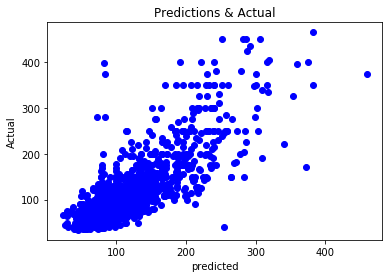

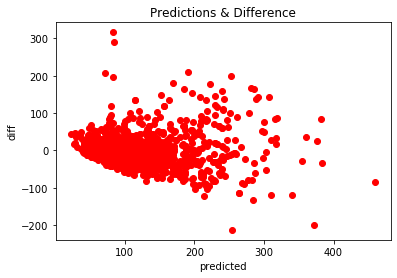

                                             est_int      coefs  abs_coefs
42                             room_type_Shared room -61.651179  61.651179
41                            room_type_Private room -34.568675  34.568675
4                                           bedrooms  27.300899  27.300899
22             neighbourhood_group_cleansed_Downtown  25.969214  25.969214
28           neighbourhood_group_cleansed_Queen Anne  21.798338  21.798338
3                                          bathrooms  19.720551  19.720551
18         neighbourhood_group_cleansed_Capitol Hill  18.304151  18.304151
21             neighbourhood_group_cleansed_Delridge -18.270660  18.270660
26            neighbourhood_group_cleansed_Northgate -18.214149  18.214149
19              neighbourhood_group_cleansed_Cascade  18.182722  18.182722
24            neighbourhood_group_cleansed_Lake City -13.271627  13.271627
29       neighbourhood_group_cleansed_Rainier Valley -11.311044  11.311044
25             neighbourh

In [23]:
model_2 = lm_mod(X2,y2)


# Model evaluation:Model 2
* Based on the train and test r2 scores, performs well on both the test and train data sets which is a good sign!
  A good sign that the model does not overfit the data.
* Combining categorical and numeric features increases the model by 9% on the test data set and 8% on the train data set.
* The features selected can predict 63% of the variations in the prices in Seattle based on the test r2 score.
* Based on the Prediction VS Actual plot, the model is performs better when predicting prices between 0 and 300.
* Model fails to predict the extreme values, this is expected and probably adding more features can improve the performance.

### Features importance
* Group features room_type,neighbourhood and bedrooms are the top 3 most significant features.
* Room_type_shared_room is the most significant and is negatively correlated. 
  This means that choosing a shared room will lower the price by 62 dollars.
* Room_type_private_room guarantees a price lower by 34 dollars.
* Choosing a listing in Downtown neigbhourhood will increase the price by 26 dollars.
  This is expected because Downtown has the highest median price 139 dollars (see Listing_EDA notebook)
* Bedrooms and bathrooms have a positive relationship with the prices(increase the price by 27 and 19 respectively)
* Host_lisitings _count have a less than unit impact on the price of the price. 
  However it should be noted that there is a negative relationship, an host with more listings will offer a lower price.
I suspect Economies of scale benefit. 

### Challenges
* There are so many categorical features which makes it hard to select the right features.
 I believe engineering and adding more categorical features might improve the model performance.
